In [1]:
from data_manager import get_data, split_data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.preprocessing import StandardScaler

ds, ds1  = get_data()

y = np.array(ds1['target'])
X = np.array(ds1.drop(['target', 'NP_Cya_bio'], axis=1)) # the data

X_sub, X_test, y_sub, y_test = split_data(X, y, 5)
X_train, X_val, y_train, y_val = split_data(X_sub, y_sub, 3)
def make_one_hot(*y):
    res = []
    for y_i in y:
        y_1hot = to_categorical(y_i)
        res.append(y_1hot)
    return res

def scale_data(*X):
    res = []
    scaler = StandardScaler()
    for X_i in X:
        scaled_X = scaler.fit_transform(X_i)
        res.append(scaled_X)
    return res

def plot_epochs_vs_loss(hist):
    training_results = hist.history
    num_epochs = len(training_results['loss'])
    epochs_pl = np.linspace(1, num_epochs, num_epochs, dtype=int)

    plt.plot(epochs_pl, training_results['loss'], label='Training')
    plt.plot(epochs_pl, training_results['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
def print_metrics(scores):
    metrics = ['Loss', 'True Positive', 'False Positive', 'True Negative',' False Negative', 'Precision','Recall','AUC']
    for score, metric in zip(scores, metrics):
        print(f'{metric}: {score}')
    

# y_train, y_val, y_test = make_one_hot(y_train, y_val, y_test) 

/home/tim/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tim/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tim/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tim/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

In [22]:
X.shape

(1298, 9)

## Lets just try to do a simple MLP to begin
### 3 Layers, 10 20 5

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import tensorflow

batch_size=32
epochs=40
learning_rate=0.001
num_classes = len(np.unique(y_train))
in_shape = X_train.shape[1:]
metrics = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'), 
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
]


# loss_func = keras.losses.CategoricalCrossentropy()
loss_func = keras.losses.BinaryCrossentropy()

model = Sequential()
model.add(Dense(30, activation='sigmoid', input_shape=in_shape, dtype=float))
model.add(Dropout(0.2))
model.add(Dense(40, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=learning_rate)
model.compile(loss=loss_func,
             optimizer=opt,
             metrics=metrics)
hist = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, y_val), verbose=0)
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('ROC AUC:', score[1])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Test loss: 0.07483978984870977
ROC AUC: 0.0


In [3]:
print(score)

[0.07483978984870977, 0.0, 0.0, 282.0, 5.0, 0.0, 0.0, 0.7648937]


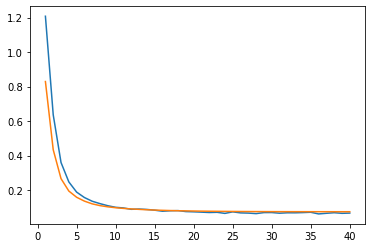

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import print as tprint
results = hist.history
epochs_pl = np.linspace(1,epochs,epochs, dtype=int)
plt.plot(epochs_pl, results['loss'])
plt.plot(epochs_pl, results['val_loss'])
predictions = model.predict(X_test)
# conf = confusion_matrix(y_test[:,1], predictions[:,1])
# predictions

# well, this doesnt work like I thought it would...
# whoops, we need more data



In [4]:
import numpy as np 

from data_manager import get_data
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

ds1, ds = get_data()
y = np.array(ds['target'])
X = np.array(ds.drop(['target', 'NP_Cya_bio'], axis=1)) # the data

X_sub, X_test, y_sub, y_test = split_data(X, y, 4)
X_train, X_val, y_train, y_val = split_data(X_sub, y_sub, 4)
X_train, X_val, X_test = scale_data(X_train, X_val, X_test)

In [358]:
import tensorflow as tf
from tensorflow import keras

neg, pos = np.bincount(ds['target'])
epochs = 100
batch_size = 512

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc', curve='PR'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        model = keras.Sequential([
            Dense(X_train.shape[-1], activation='relu',
              input_shape=(X_train.shape[-1],)),
            Dense(30, activation='relu'),
            Dropout(0.5),
            Dense(40, activation='relu'),
            Dropout(0.5),
            Dense(20, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid',
                             bias_initializer=output_bias),
        ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.0005),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

epochs = 200
batch_size = 512

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

initial_bias = np.log(pos/neg)
model = make_model(output_bias = initial_bias)

# results = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
# print("Loss: {:0.4f}".format(results[0]))

Loss: 0.042188086325484445
True Positive: 0.0
False Positive: 0.0
True Negative: 283.0
 False Negative: 4.0
Precision: 0.0
Recall: 0.0
AUC: 0.9739399552345276


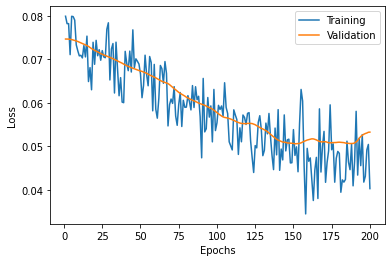

In [135]:
hist = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
#                 callbacks=[early_stopping],
                validation_data=(X_val, y_val), verbose=0)
plot_epochs_vs_loss(hist)
score = model.evaluate(X_test, y_test, verbose=0)
print_metrics(score)

### Class weights
In SVM, we used 'balanced' class weights to give the positive class more power.

In [404]:

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        model = keras.Sequential([
            Dense(9, activation='relu',
              input_shape=(X_train.shape[-1],)),
            Dense(12, activation='relu'),
            Dropout(.2),
            Dense(10, activation='relu'),
            Dropout(0.2),
#             Dense(12, activation='relu'),
#             Dropout(0.4),
            Dense(5, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid',
                             bias_initializer=output_bias),
        ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.005),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)



Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Loss: 0.05548575957945
True Positive: 1.0
False Positive: 0.0
True Negative: 283.0
 False Negative: 3.0
Precision: 1.0
Recall: 0.25
AUC: 0.78121018409729


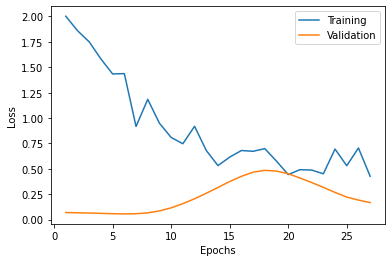

In [396]:
total = neg+pos
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

model = make_model(output_bias = initial_bias)
hist = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, y_val), 
                class_weight=class_weight,
                callbacks=[early_stopping],
                verbose=0)
plot_epochs_vs_loss(hist)
score = model.evaluate(X_test, y_test, verbose=0)
print_metrics(score)


### Try oversampling the minority class 
#### (this is the best!)


In [402]:
ds1, ds = get_data()
y = np.array(ds['target'])
X = np.array(ds.drop(['target', 'NP_Cya_bio'], axis=1)) # the data

X_sub, X_test, y_sub, y_test = split_data(X, y, 4)
X_train, X_val, y_train, y_val = split_data(X_sub, y_sub, 4, test_size=.25)
X_train, X_val, X_test = scale_data(X_train, X_val, X_test)

pos_idxs, neg_idxs = np.where(y_train == 1)[0], np.where(y_train == 0)[0]
ids = np.arange(len(pos_idxs))
choices = np.random.choice(ids, len(neg_idxs))
over_sampled_pos_idxs = pos_idxs[choices]
X_neg, y_neg = X_train[neg_idxs], y_train[neg_idxs]
X_pos_over_sampled, y_pos_over_sampled = X_train[over_sampled_pos_idxs], y_train[over_sampled_pos_idxs]

## now concatonate the original data with this data!
X_train_oversampled = np.r_[X_neg,X_pos_over_sampled]
y_train_oversampled = np.r_[y_neg, y_pos_over_sampled]

print(f'Oversampled data shapes \nFeatures: {X_train_oversampled.shape}\nLabels: {y_train_oversampled.shape}')
order = np.arange(len(X_train_oversampled))
np.random.shuffle(order)
X_train_oversampled, y_train_oversampled = X_train_oversampled[order], y_train_oversampled[order]

Oversampled data shapes 
Features: (1692, 9)
Labels: (1692,)


In [416]:
# we dont want to initialize the bias here
def make_model(metrics = METRICS):
    model = keras.Sequential([
        Dense(9, activation='relu',
          input_shape=(X_train.shape[-1],)),
        Dense(5, activation='relu'),
        Dropout(.2),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid'),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.005),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Loss: 0.047758084822059794
True Positive: 3.0
False Positive: 7.0
True Negative: 276.0
 False Negative: 1.0
Precision: 0.30000001192092896
Recall: 0.75
AUC: 0.29490381479263306


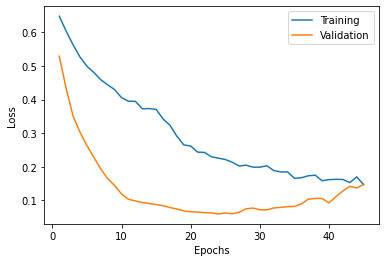

In [418]:

model = make_model()
    
hist = model.fit(X_train_oversampled, y_train_oversampled,
                batch_size=256,
                    epochs=100,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping],
                verbose=0)


plot_epochs_vs_loss(hist)
score = model.evaluate(X_test, y_test, verbose=0)
print_metrics(score)
plt.savefig('figures/nn_loss.png',format='png')

# Expanding Window Training

In [425]:
from data_manager import get_data
import numpy as np

class ExpandingWindow:
    
    def __init__(self):
        self.ds = self.__clean_data()    
        self.sorted_ds = self.__sort_by_date()
        self.X = np.array(self.sorted_ds.drop(['NP_Cya_bio', 'target','Date'], axis=1))
        self.y = np.array(self.sorted_ds['target'])
        self.years = self.__get_year()
        self.hist = []
        self.score = []
        
    def __sort_by_date(self):
        return self.ds.sort_values('Date')
    
    def __get_year(self):
        return pd.DatetimeIndex(self.sorted_ds['Date']).year
    
    def __clean_data(self):
        ds1 = pd.read_csv('data/AllSites.csv')
        threshold = np.where(ds1['NP_Cya_bio'] >= 4e8)
        target = np.zeros(len(ds1['NP_Cya_bio']))
        target[threshold] = 1
        ds1['target'] = pd.Series(target)
        ds1 = ds1.dropna(axis=0, subset = ['NP_Cya_bio'])
        ds2 = ds1.drop(['Station', 'Stratum','Date','StationID','Time', 'Depth'], axis=1)
        ds2['TP'] = ds1['TP'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
        ds2['Cl'] = ds1['Cl'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
        ds2['DP'] = ds1['DP'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
        ds2['TN'] = ds1['TN'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
        ds2['TempC'] = ds1['TempC'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
        ds2['Chla'] = ds1['Chla'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
        ds2['Secchi'] = ds1['Secchi'].astype(str).str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
        ds2['N:P'] = ((ds2['TN']*1e-3)/14.007)/((ds2['TP']*1e-6)/30.974) #for TN in ds2['TN'] for TP in ds2['TP']]
        ds2['Month'] = ds1['Date'].astype(str).str.extract('(\d+)').astype(int) # This is just the month number
        for colname in ds2:
            ds2[colname] = ds2[colname].fillna(ds2.groupby('Month')[colname].transform('mean'))
        ds2['Date'] = pd.to_datetime(ds1.Date)
        return ds2.dropna(axis=0, how='any')
    
    def set_model(self, model):
        self.model = model
    
    def get_model(self):
        return self.model
    
    def oversample(self, X_train, y_train):
        pos_idxs, neg_idxs = np.where(y_train == 1)[0], np.where(y_train == 0)[0]
        ids = np.arange(len(pos_idxs))
        choices = np.random.choice(ids, len(neg_idxs))
        over_sampled_pos_idxs = pos_idxs[choices]
        X_neg, y_neg = X_train[neg_idxs], y_train[neg_idxs]
        X_pos_over_sampled, y_pos_over_sampled = X_train[over_sampled_pos_idxs], y_train[over_sampled_pos_idxs]

        ## now concatonate the original data with this data!
        X_train_oversampled = np.r_[X_neg,X_pos_over_sampled]
        y_train_oversampled = np.r_[y_neg, y_pos_over_sampled]

        print(f'Oversampled data shapes \nFeatures: {X_train_oversampled.shape}\nLabels: {y_train_oversampled.shape}')
        order = np.arange(len(X_train_oversampled))
        np.random.shuffle(order)
        X_train_oversampled, y_train_oversampled = X_train_oversampled[order], y_train_oversampled[order]
        return X_train_oversampled, y_train_oversampled
    
    
    def fit(self, **kw):
        assert hasattr(self, 'model'), "Please specify model using set_model()"
        return self.forcast_testing(**kw)

    def forcast_testing(self, **kw):
            current_year = 2006
            done = False
            while not done:
                train_indices = np.where(self.years <= current_year)[0] # the years we are training on
                test_indices = np.where(self.years == current_year+1)[0]
                X_train, y_train = self.X[train_indices], self.y[train_indices]
                X_train_oversampled, y_train_oversampled = self.oversample(X_train, y_train)
                X_test, y_test = self.X[test_indices], self.y[test_indices]
                self.hist.append(self.model.fit(X_train_oversampled, y_train_oversampled, **kw))

                self.score.append(model.evaluate(X_test, y_test, verbose=0))
#                 print_metrics(score)
                current_year += 1
                if current_year+1 == 2015:
                    done = True
    
        
        
        
inst = ExpandingWindow()
inst.set_model(model)
model_params = {'batch_size': batch_size,
                'epochs': epochs,
#                 'validation_data': (X_val, y_val),
                'callbacks': [early_stopping],
                'verbose': 0
}
inst.fit(**model_params)



# inst.set_model(model)
# hist = inst.fit(**stuff)

# plot_epochs_vs_loss(hist)
# score = model.evaluate(X_test, y_test, verbose=0)
# print_metrics(score)

Oversampled data shapes 
Features: (308, 9)
Labels: (308,)
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Oversampled data shapes 
Features: (584, 9)
Labels: (584,)
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
Oversampled data shapes 
Features: (896, 9)
Labels: (896,)
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Oversampled data shapes 
Features: (1226, 9)
Labels: (1226,)
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
Oversampled data shapes 
Features: (1538, 9)
Labels: (1538,)
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Oversampled data shapes 
Features: (1820, 9)
Labels: (1820,)
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Oversampled data shapes 
Features: (2090, 9)
Labels: (2090,)
Restoring model weights from the end of the best epoch.
Epoch 00011: early 

In [420]:
scores = inst.score
for score in scores:
    print_metrics(score)
    print('\n')


Loss: 0.4861554019693015
True Positive: 0.0
False Positive: 43.0
True Negative: 95.0
 False Negative: 0.0
Precision: 0.0
Recall: 0.0
AUC: 0.0


Loss: 0.08568781237551741
True Positive: 2.0
False Positive: 9.0
True Negative: 147.0
 False Negative: 0.0
Precision: 0.1818181872367859
Recall: 1.0
AUC: 0.2222222238779068


Loss: 0.06890963758483146
True Positive: 0.0
False Positive: 7.0
True Negative: 158.0
 False Negative: 0.0
Precision: 0.0
Recall: 0.0
AUC: 0.0


Loss: 0.09643066617158744
True Positive: 0.0
False Positive: 9.0
True Negative: 147.0
 False Negative: 0.0
Precision: 0.0
Recall: 0.0
AUC: 0.0


Loss: 5.176322727981541
True Positive: 1.0
False Positive: 11.0
True Negative: 130.0
 False Negative: 2.0
Precision: 0.0833333358168602
Recall: 0.3333333432674408
AUC: 0.050290629267692566


Loss: 0.2596489927807082
True Positive: 1.0
False Positive: 20.0
True Negative: 115.0
 False Negative: 1.0
Precision: 0.0476190485060215
Recall: 0.5
AUC: 0.058608829975128174


Loss: 0.283109048255404

###  This would be good to put in the presentation

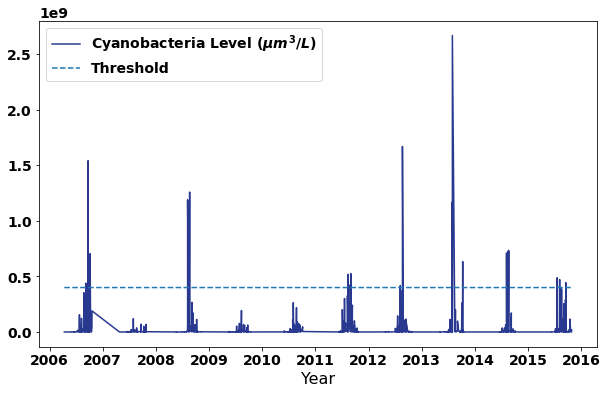

In [466]:
import matplotlib.pyplot as plt
import matplotlib 
font = {
#     'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)
%config InlineBackend.image_format='svg'
line_d = 4e8*np.ones(len(inst.sorted_ds['Date']))
plt.figure(figsize=(10,6))
plt.plot(inst.sorted_ds['Date'], inst.sorted_ds['NP_Cya_bio'], label=r'Cyanobacteria Level ($μm^3/L$)', c='#2a3990')
plt.plot(inst.sorted_ds['Date'], line_d, ls='--', label='Threshold')
plt.xlabel('Year',fontsize=16)
# plt.ylabel(r'Cyanobacteria Level ($μm^3/L$)')
plt.legend()
